In [1]:
def clean_quotes(text_line):
  # code to remove quotes - iterate through all lines in the books first
  # the next two lines are for removing discrepancies in the types of quotes used throughout the corpus!
  clean_line = re.sub(r"’|‘", "'", text_line)
  clean_line = re.sub(r'“|”', '"', clean_line)

  # removes dialogue in place
  clean_line = re.sub(r'"\w[\w.,\'!?…:\-—\s]*"', '', clean_line)
  return clean_line

In [2]:
def augment_pronouns(line, narrator):
  """code to add in narrators to first-person pronouns for each line of text
  line is a raw string of text from a book; narrator is the narrator of that book"""
  # this regex identifies all pronouns that we are interested in replacing
  regex = re.compile(r"\bI\s|\b[mM][ey]+\s|\b[mM]yself\s|\bI'[a-z]+\s")
  matches = regex.findall(next_line)
  matches = [matches[i].strip() for i in range(len(matches))]

  # replace word matches with narrator appended version of each word
  modifiedlist = [word + '_' + narrator if word in matches else word for word in next_line.split()]
  # turn back into a string!
  string = ' '.join(modifiedlist)


In [3]:
# Python built-in imports
import csv
import os
import re

# Library imports (these may need to be installed)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn

In [4]:
# We have three topic models with 10, 20, and 50 topics - this code
# will help automatically select the files from the right model.
# Change ntopics to 10, 20, or 50 if needed - don't hardcode anywhere else.
ntopics = 20
data_path = "/Users/qad/Documents/dsc/dsc_topicmodels/"
model_path = data_path + "{}topics/".format(ntopics)

# This reads in the base dataframe, with 2 + ntopics columns
doctopics_df = pd.read_csv(
    os.path.join(model_path,"dsc.doctopics.txt"),
    delimiter="\t",
    names=["id", "segment_name"]+[str(i) for i in range(ntopics)])

In [5]:
# Two helper functions to help us extract names of books and chapters from the segment ids,
# keeping in mind that most chapters are broken into segments
# Example: 002c_claudia_and_the_phantom_phone_calls_5.txt-4
# book: 002c_claudia_and_the_phantom_phone_calls
# chapter: 5
def get_chapter_from_name(name):
    return int(re.match(r".*_([0-9]+)\.txt-*", name).group(1))

def get_book_from_name(name):
    return re.match(r"(.*)_[0-9]+\.txt-*", name).group(1)

# Adding chapter and book columns to our dataframe
doctopics_df['chapter'] = doctopics_df.apply(lambda row: get_chapter_from_name(row.segment_name), axis = 1)
doctopics_df['book'] = doctopics_df.apply(lambda row: get_book_from_name(row.segment_name), axis = 1)

In [6]:
# We're going to want to see the original documents, so we'll load them in too
docs_df = pd.read_csv(
    os.path.join(data_path, "dsc_chunks_by_chapter_and_narrator.tsv"),
    delimiter="\t",
    quoting=3,
    names=["id", "narrator_chapter", "text"])

# Adding a narrator column to our data frame
segment_to_sitter = {}
for _, row in docs_df.iterrows():
    segment_to_sitter[row["id"]] = row["narrator_chapter"].split('_')[0]
doctopics_df['narrator'] = doctopics_df.apply(lambda row: segment_to_sitter[row.segment_name], axis = 1)

In [7]:
# State file loading! Fun fact: the "state file" containing all the detail
# about a trained topic model is stored in a compressed "gzip" format, but
# Pandas knows how to deal with this if we tell it that it's compressed:
state_df = pd.read_csv(os.path.join(model_path, "dsc1.txt.gz"),
                       compression="gzip",
                       delimiter=" ",
                       skiprows=[1, 2])

# We're going to want to combine the segments together (e.g. by book, by chapter, or
# by narrator), but not all our segments are the same length! To help with this, we
# are going to keep track of # tokens per topic so we can weight our topic averages by
# how many tokens are in each segment
doctopics_df['ntokens'] = state_df.groupby("#doc")['#doc'].count()
doctopics_df['ntokens'] = doctopics_df['ntokens'].fillna(0)

In [8]:
# Let's get book-level topic proportions!
book_df = pd.DataFrame()
for i in range(ntopics):
    book_df[str(i)] = doctopics_df.groupby('book').apply(lambda gp: np.average(gp[str(i)], weights=gp['ntokens']))

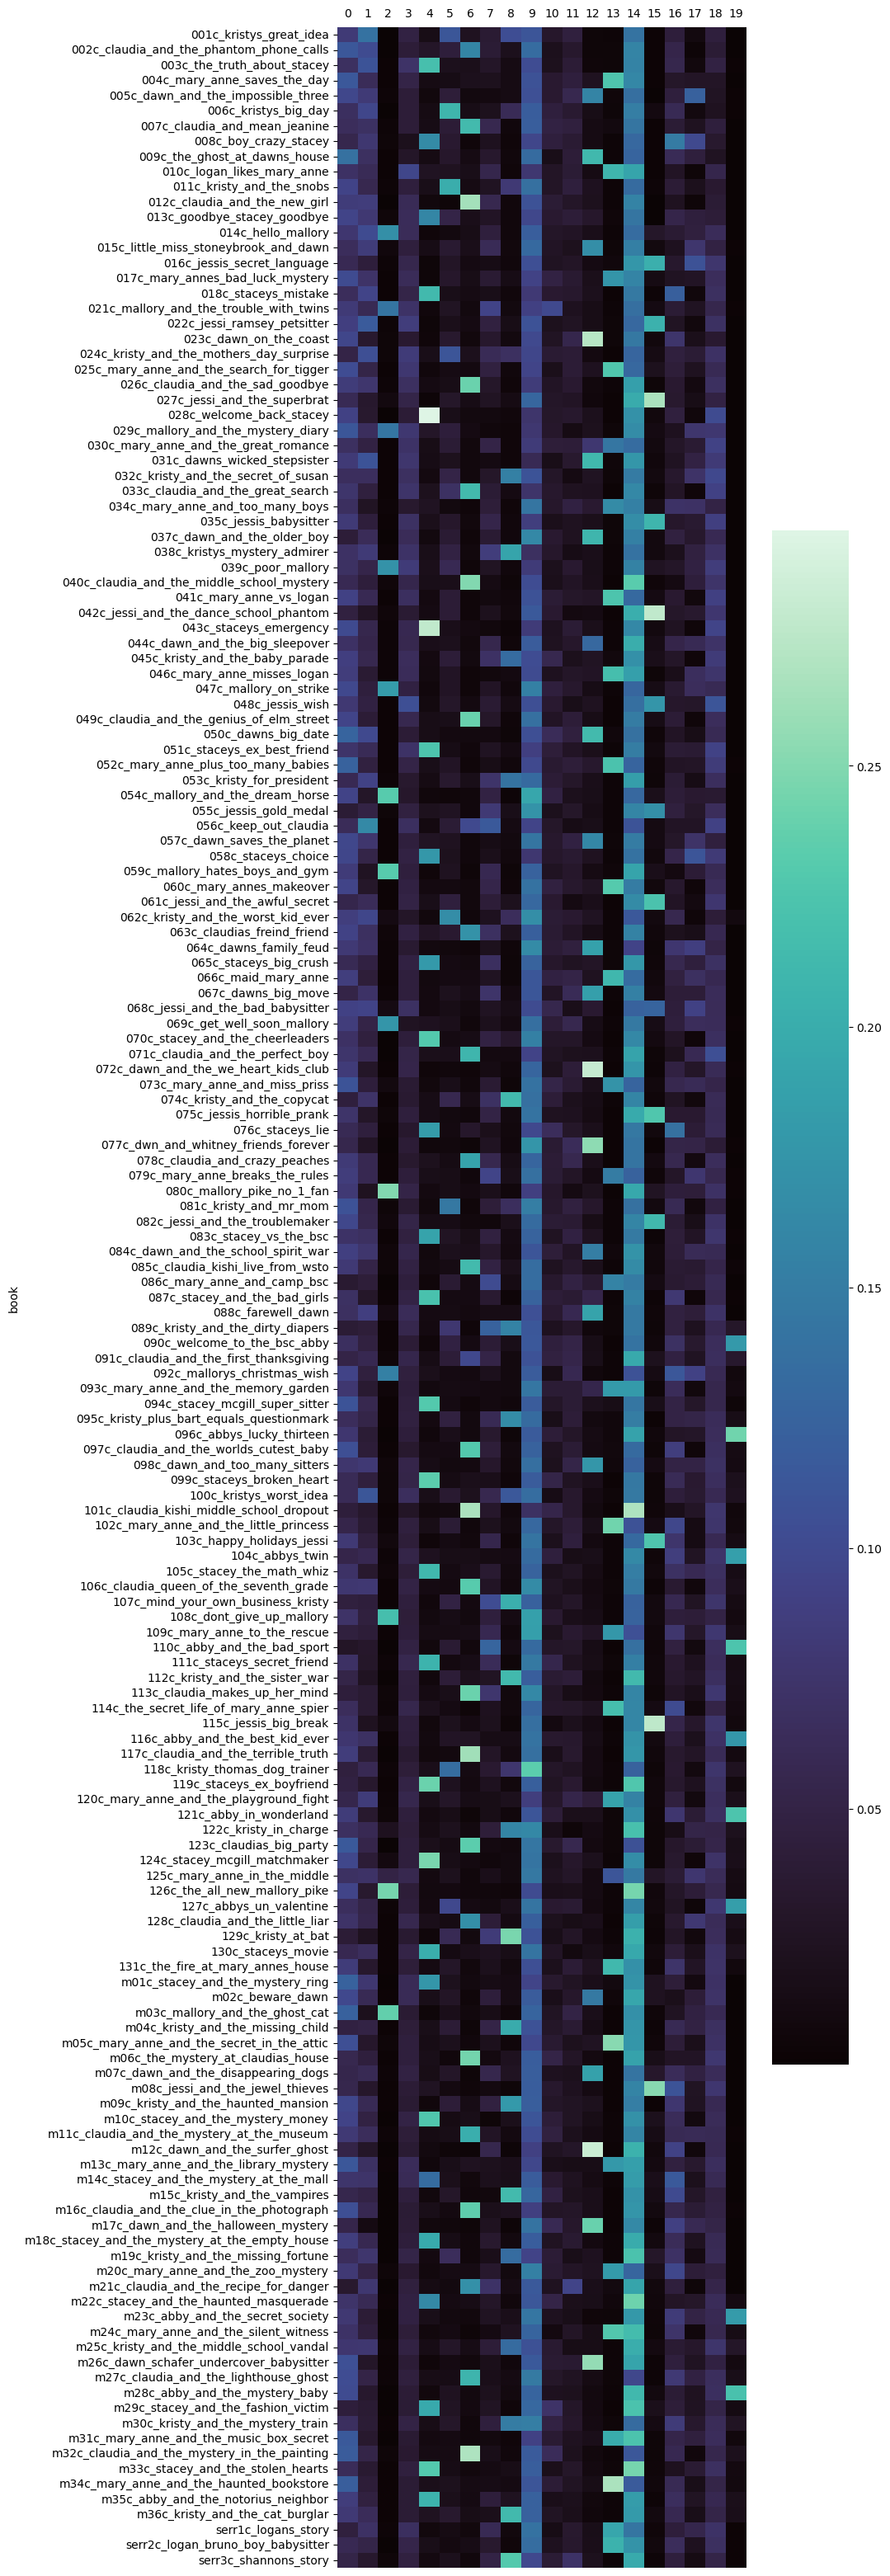

In [9]:
# Plotting books by topics
plt.figure(figsize=(8,40))
seaborn.heatmap(book_df, cmap='mako')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

<AxesSubplot:ylabel='narrator'>

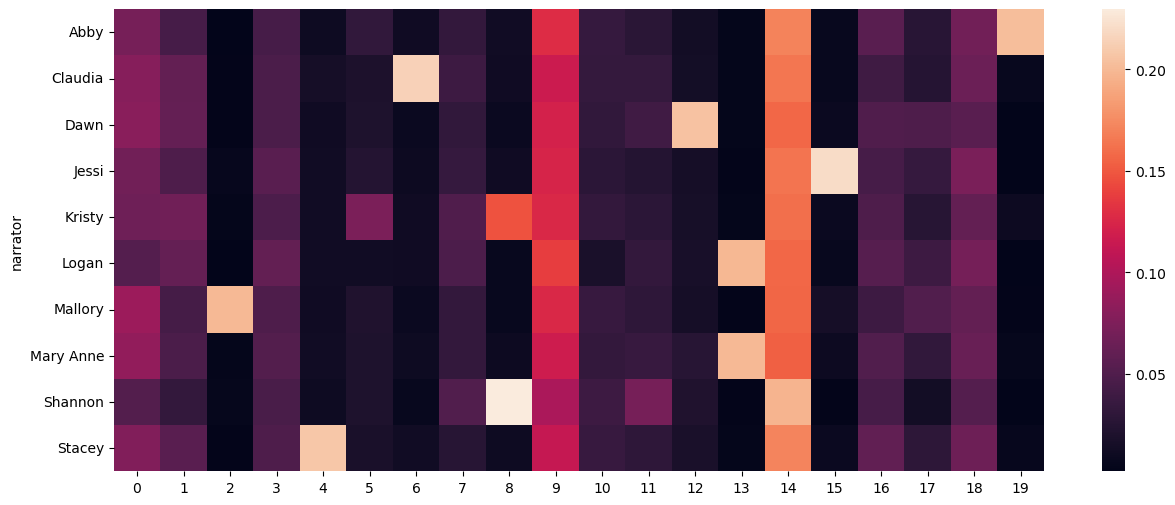

In [10]:
# Plotting narrators by topics
plt.figure(figsize=(15,6))
narrator_df = pd.DataFrame()
for i in range(ntopics):
    narrator_df[str(i)] = doctopics_df.groupby('narrator').apply(lambda gp: np.average(gp[str(i)], weights=gp['ntokens']))
seaborn.heatmap(narrator_df)

In [11]:
# Per-chapter aggregation of topic proportions
chapter_df = pd.DataFrame()
for i in range(ntopics):
    chapter_df[str(i)] = doctopics_df.groupby('chapter').apply(lambda gp: np.average(gp[str(i)], weights=gp['ntokens']))

# This is a hacky way to try to get one row for each individual topic-document proportion,
# which will help split plots into other dimensions over chapters
data = []
for row in doctopics_df.itertuples():
    for k in range(ntopics):
        # segment, topic, chapter, book, narrator, proportion, n_tokens
        data.append([row[2], str(k), row[3+ntopics], row[4+ntopics], row[5+ntopics], row[3+k], row[6+ntopics]])

topic_obs_df = pd.DataFrame(data, columns=["segment_name", "topic", "chapter", "book", "narrator", "proportion", "n_tokens"])

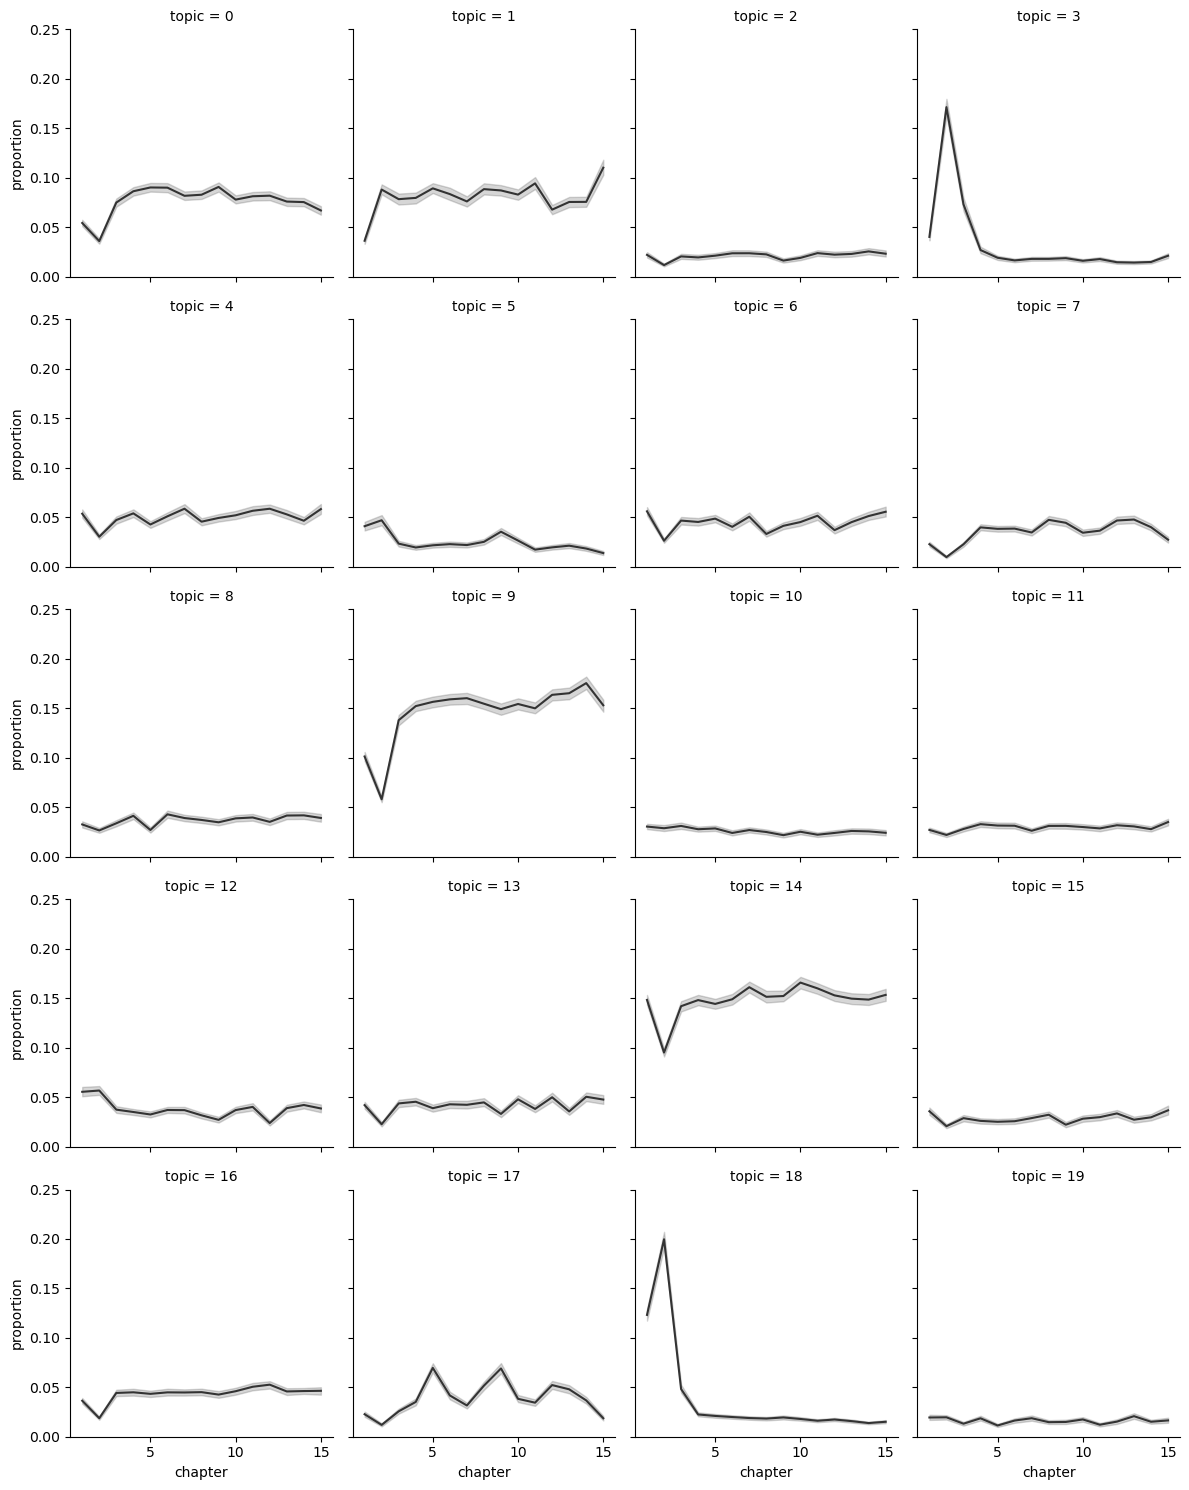

In [12]:
# Borrowing from https://seaborn.pydata.org/tutorial/axis_grids.html
# Topics over chapters
g = seaborn.FacetGrid(topic_obs_df, col="topic", col_wrap=4, ylim=(0,0.25))
g.map(seaborn.lineplot, "chapter", "proportion", color="0.2")

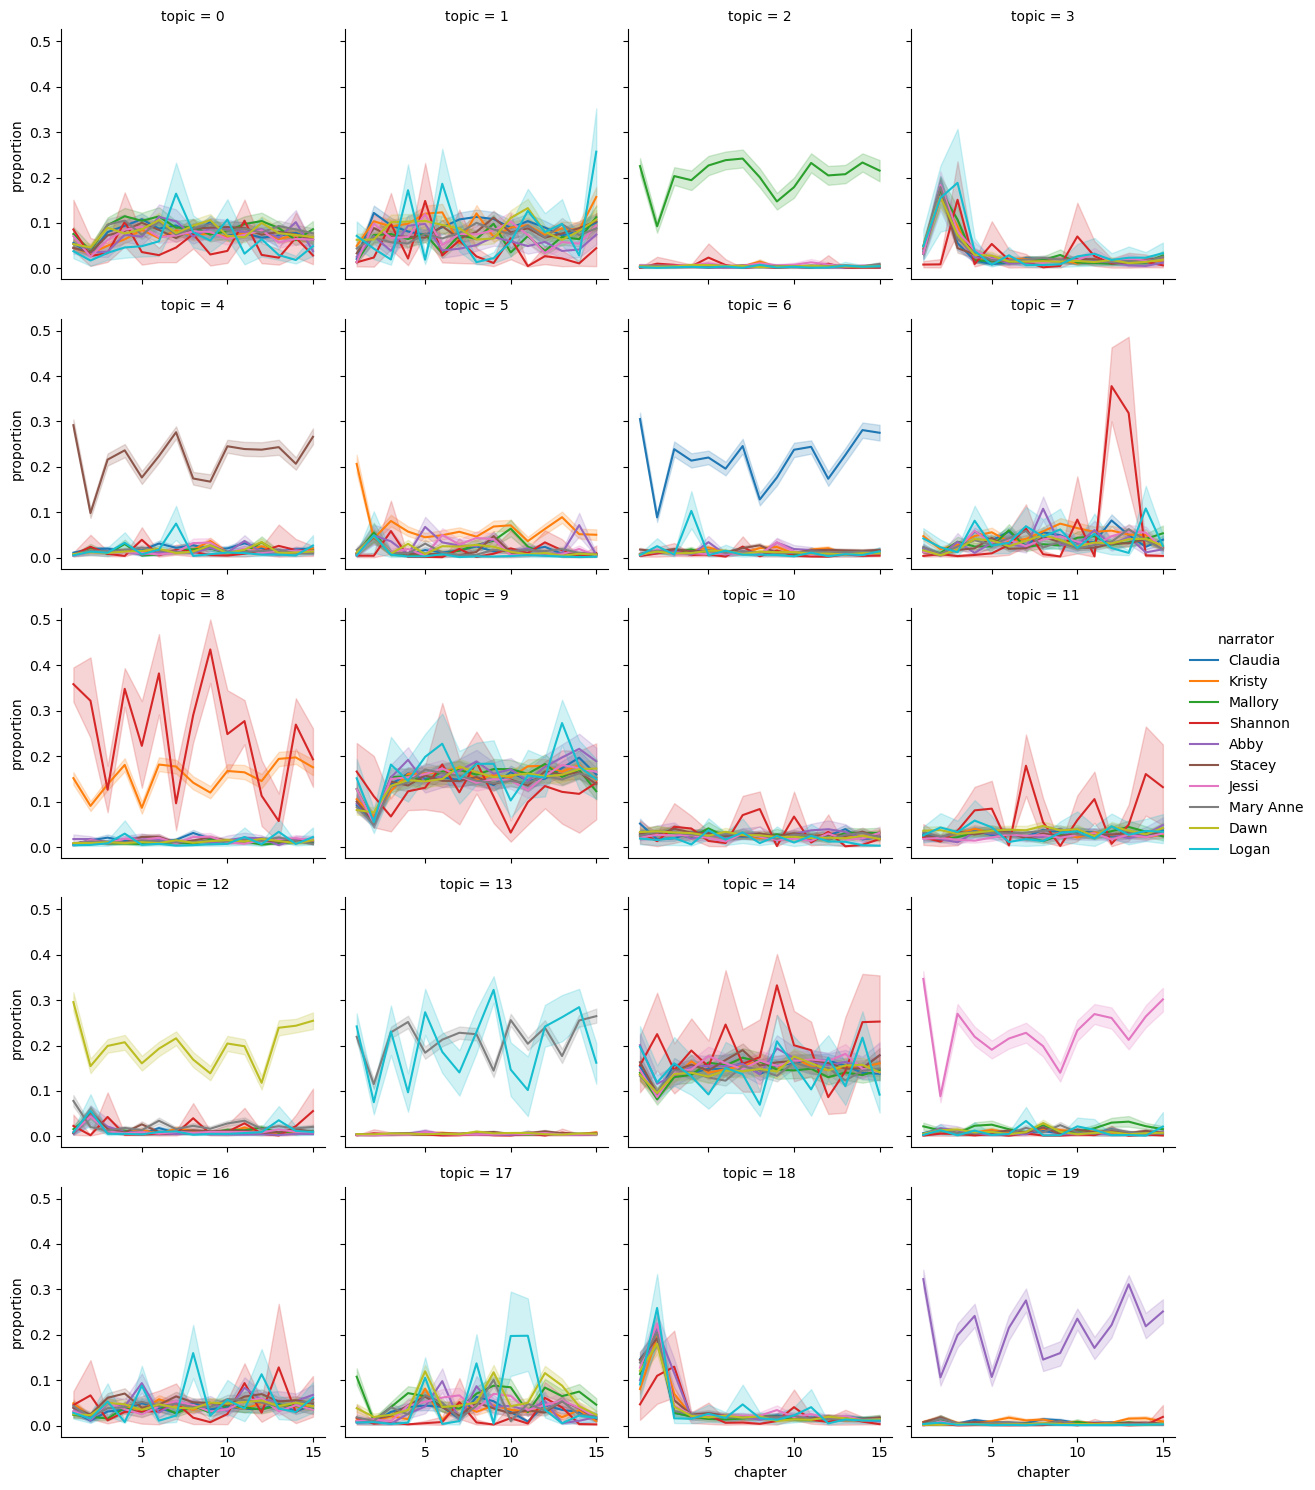

In [13]:
# Again, but broken down by narrator -- too much data! (Also runs slowly!)
g = seaborn.FacetGrid(topic_obs_df, col="topic", hue="narrator", col_wrap=4, sharey=True)
g.map(seaborn.lineplot, "chapter", "proportion")
g.add_legend()

In [14]:
def get_top_docs_for_topic(topic_no, k=10):
  top_k_idxs = doctopics_df.sort_values(str(topic_no), ascending=False).head(k)
  top_k_data = pd.merge(top_k_idxs, docs_df, how="inner", left_on=['segment_name'], right_on=['id'])
  for idx, row in top_k_data.iterrows():
    print("**{} - {}, Chapter {} ({:.2%})** {}\n".format(row['segment_name'], row['narrator'], row['chapter'], row[str(topic_no)], row['text']))

get_top_docs_for_topic(3)

**127c_abbys_un_valentine_2.txt-7 - Abby, Chapter 2 (97.07%)** We meet Monday, Wednesday, and Friday afternoons, from five-thirty until six at Claudia's. Clients know that if they call us during meeting times, they'll reach six reliable, experienced baby-sitters. Since Claudia has her own phone number, the line isn't busy with family calls (and Claud's family isn't prevented from using the phone while we are meeting). When a client calls, Mary Anne checks the record book to see who is available and we schedule the baby-sitting appointment. We pay dues every Monday. The club uses the money to pay Kristy's older brother Charlie for gas (he usually drives Kristy and me to meeting — I live two houses down the street from Kristy), to contribute to Claudia's refreshments fund, to splurge on the occasional pizza party, and to keep our Kid-Kits stocked.

**042c_jessi_and_the_dance_school_phantom_4.txt-8 - Jessi, Chapter 4 (96.99%)** Where does the money come from? Well, it’s like this. We keep

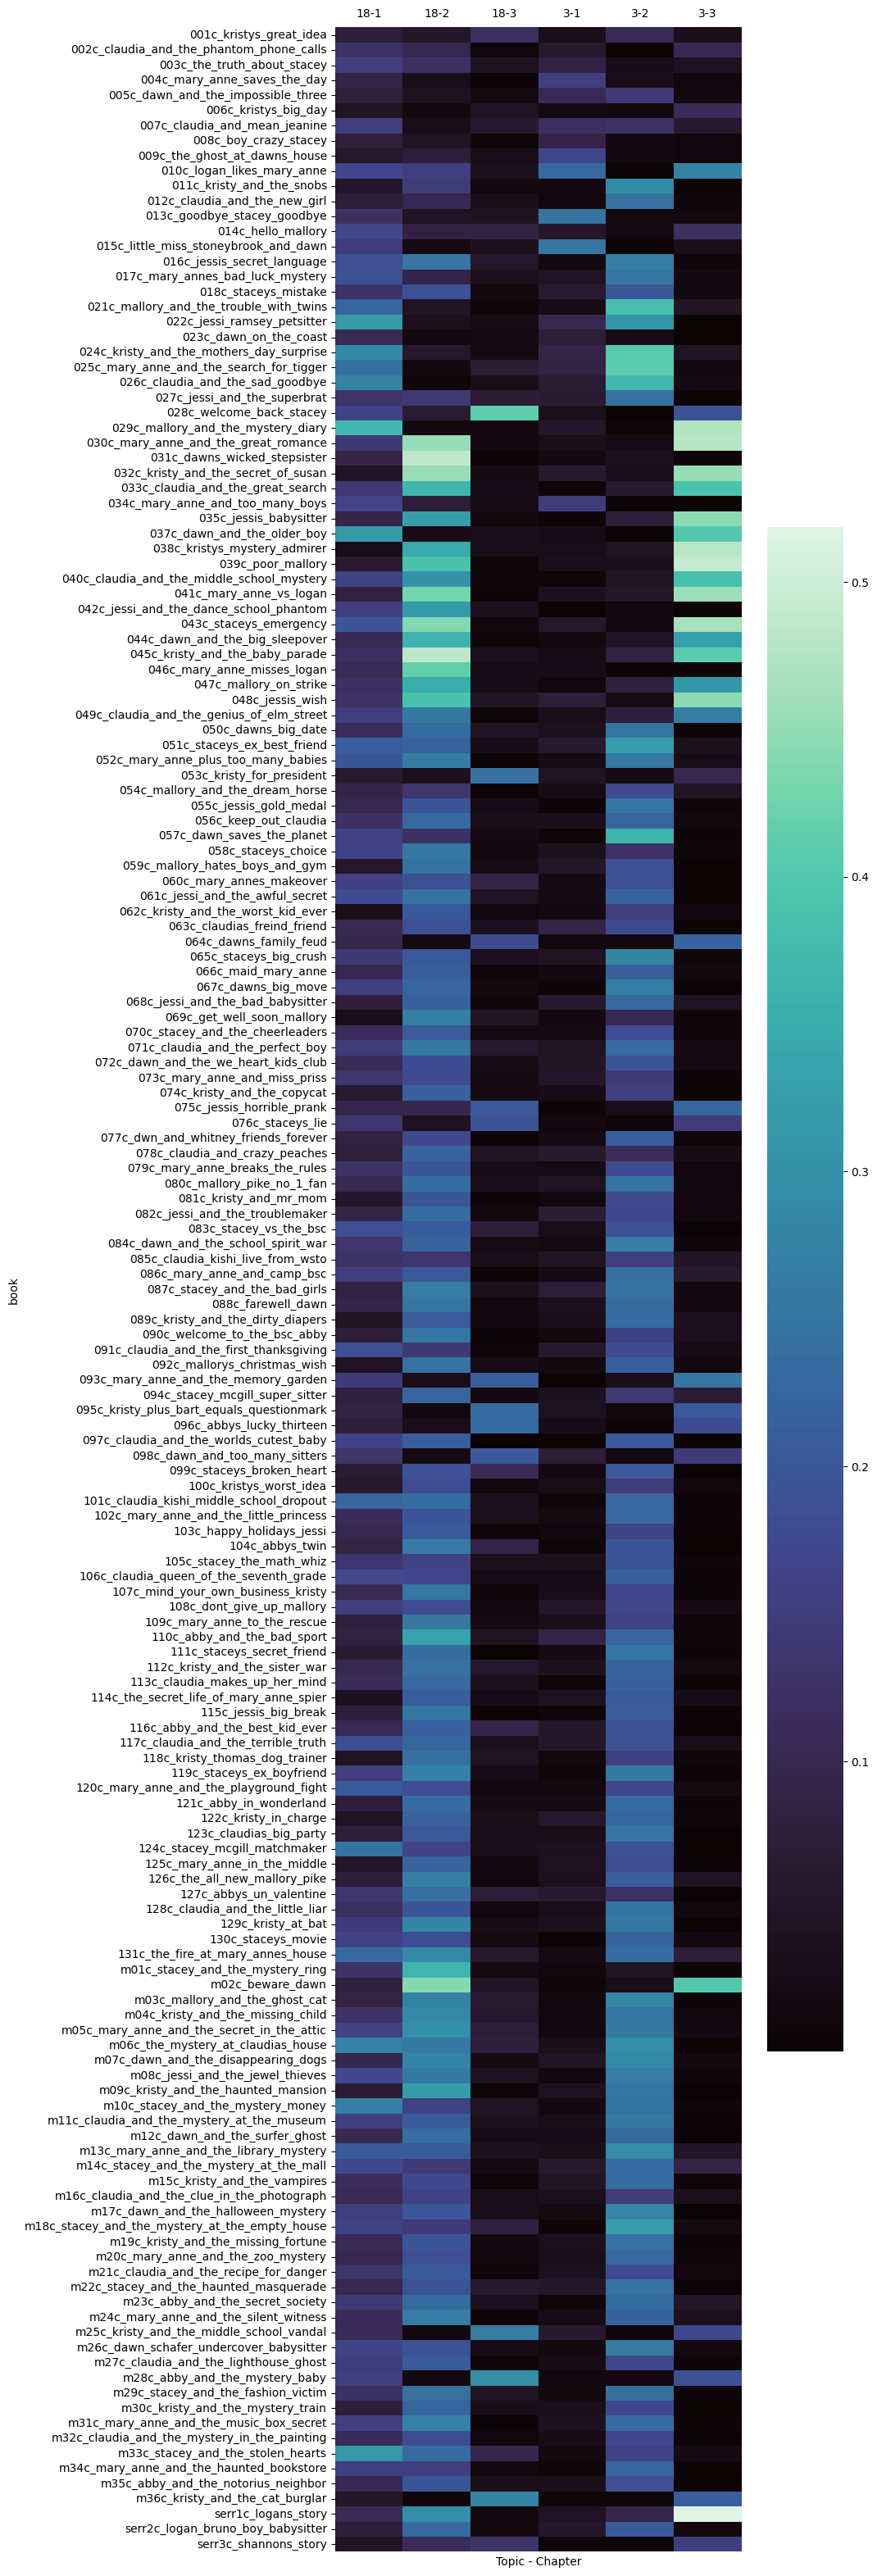

In [15]:
ch_2_topics = [3, 18]
ch_2_topic_df = doctopics_df.query('chapter < 4')[
                    ['segment_name', 'book', 'narrator', 'chapter'] + [str(k) for k in ch_2_topics]
                ].rename({str(k): 'proportion'}).pivot_table(index='book', columns='chapter', values=[str(k) for k in ch_2_topics], aggfunc='mean')

# Plotting chapters 1, 2, and 3 across books for hypothesized "chapter 2" topics
plt.figure(figsize=(8,40))
seaborn.heatmap(ch_2_topic_df, cmap='mako')
plt.xlabel("Topic - Chapter")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False,
                bottom=False, top = False, labeltop=True)

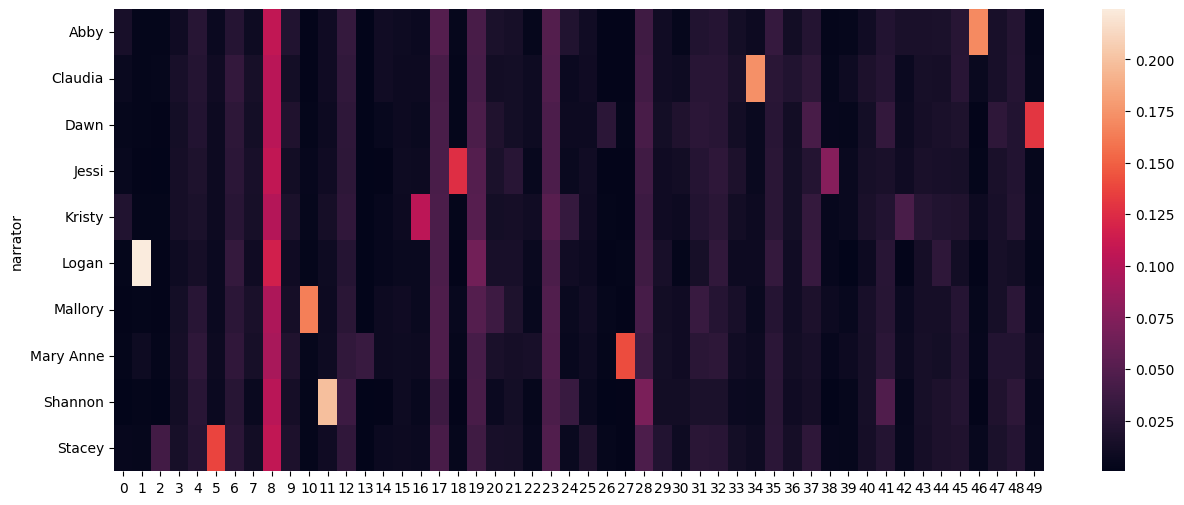

In [16]:
from IPython.display import Image
Image(data_path + "50_topic_by_narrator.png")